# 236756 - Machine Learning - Exercise 4
### Ron Sailer
### Adam Erdreich

# Task 1 - Steady Coalition

After predicting which voters will vote to which party, we wish to predict a steady coalition, which in our terms will mean dividing the 7-dimension-hyperspace into 2 groups, clusters, the bigger of which will be the coalition and the smaller one is the opposition.

but - we cannot just take any division of the voters, because a coalition consists of whole parties and not individual voters, so our each of our clusters must properly contain whole parties (meaning - all predicted voters for that party).

we'll need to devise some single scoring function that can rank such a division, based on how homogeneous the coalition is, and how far it is from the opposition.

technically, given this score can be calculated in a short time, we can try all possible party combinations (just 2^10, 1024, options, at least half of which will not actually be a valid coalition with 51% or more votes), and choose the one with the highest score - but we'll try a smarter approach, somewhat similar to Agglomerative clustering - starting with 10 clusters, one for each party, then unifying clusters greedily based on some measurement (e.g. - the two "closest" clusters) until we are left with only two - the larger of which will be the coalition (assuming it will have more then 51% of votes).

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from itertools import combinations

from sklearn import metrics
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, scale, FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


#classifiers
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.ensemble import RandomForestClassifier

pd.set_option('display.max_columns', 100) # to display all columns at all time
pd.options.mode.chained_assignment = None # to ignore false-positive warnings about chained assignments
from repoze.lru import lru_cache # user-implemented lru_cache attribute, similar to standrad one in python 3.3


In [2]:
data = pd.read_csv('ElectionsData.csv',header=0)
train = pd.read_csv('modified/afterpp_train.csv', header=0)
test = pd.read_csv('modified/afterpp_test.csv', header=0)

# merged train and test
train_test = pd.concat([train, test], keys=['train', 'test'])

for df in [train,test,train_test]:
    df.drop([x for x in df.columns.values if 'Unnamed' in x],axis=1,inplace=True)

In [3]:
train_data = train.drop(['Vote'],axis=1)
train_data_labels = train['Vote']

X_train, X_test, Y_train, Y_test = train_test_split(train_data,train_data_labels)

test_data = test.drop(['Vote'],axis=1)
test_labels = test['Vote']

party_names = set(np.unique(data['Vote']))
n_parties = len(party_names)

def print_metrics(clf):
    clf.fit(X_train, Y_train)
    test_pred = clf.predict(X_test)
    print "accuracy:", metrics.accuracy_score(Y_test, test_pred)
    print "precision:", metrics.precision_score(Y_test, test_pred,average='weighted')
    print "recall:", metrics.recall_score(Y_test, test_pred,average='macro')
    print "f1 score:", metrics.f1_score(Y_test, test_pred,average='weighted')

In [4]:
gaussian_nb = GaussianNB() # The Naive Bayes Classifiers don't have parameters to tune with SKF...
print_metrics(gaussian_nb)

accuracy: 0.605333333333
precision: 0.639521882967
recall: 0.669354037064
f1 score: 0.585904778779


In [26]:
bernoulli_nb = BernoulliNB() # The Naive Bayes Classifiers don't have parameters to tune with SKF...
print_metrics(bernoulli_nb)

accuracy: 0.411333333333
precision: 0.23354700149
recall: 0.456722683763
f1 score: 0.279882904901


In [6]:
multinomial_nb = MultinomialNB() # The Naive Bayes Classifiers don't have parameters to tune with SKF...
print_metrics(multinomial_nb)

accuracy: 0.379333333333
precision: 0.169480296763
recall: 0.357425742574
f1 score: 0.224865729241


In [7]:
forest = RandomForestClassifier(n_estimators = 60,criterion='gini',n_jobs=-1,random_state=1)
print_metrics(forest)

accuracy: 0.859333333333
precision: 0.861154200226
recall: 0.896211386751
f1 score: 0.859701140433


as we can see, Gaussian Naive Bayes has the best performance compared to the other Naive Bayes ones, but still less accurate than our best discrimintive classifier from HW03, the Random Forest.

But - as we learned, although at the bottom line the predicted label per voter happens to be less accurate, the model itself gives us extra infomation about relationships between the entire data, and not just about the labels given the data, which should end up helping us divie the voters into coalition and opposition.

Let's take a closer look at the predictions, compared to those of HW3, and see what we can find out:

In [8]:
clf = gaussian_nb

clf.fit(train_data, train_data_labels)
predictions = clf.predict(test_data)

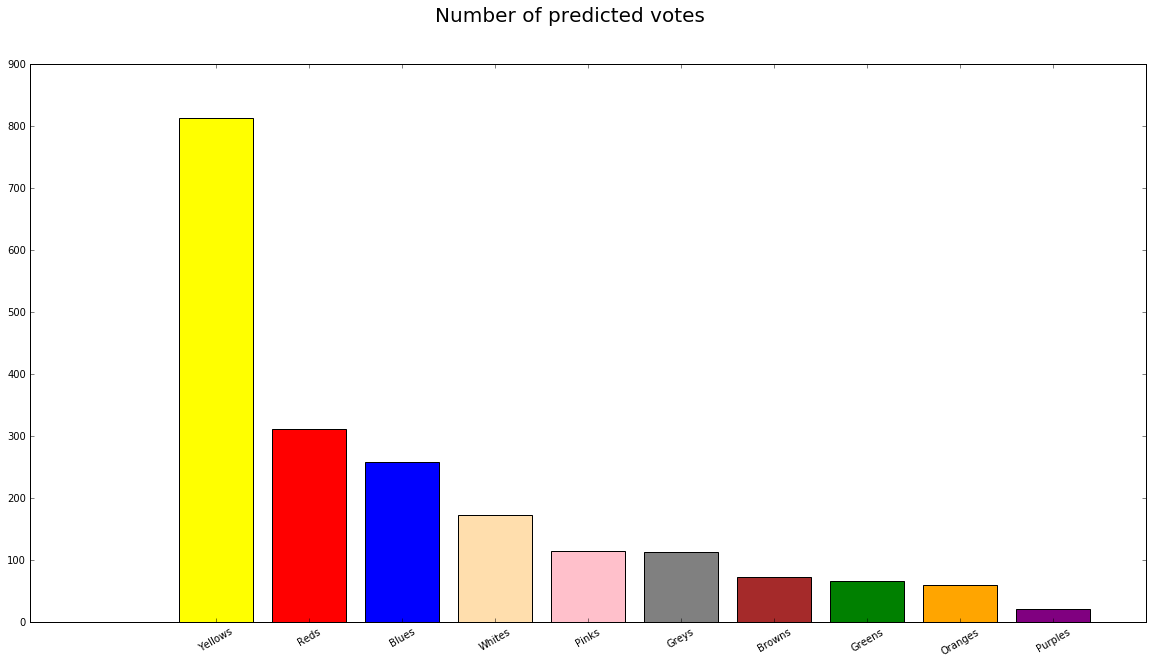

In [9]:
c = Counter(predictions)
    
c = c.most_common()
parties, votes = zip(*[x for x in c])

colors = [x[:-1] if x != 'Whites' else 'navajowhite' for x in parties]

f, ax = plt.subplots(figsize=(20, 10))
f.suptitle('Number of predicted votes',fontsize=20)
ax.bar(range(len(c)), [x[1] for x in c], align="center",color=colors)
plt.xticks(range(len(c)), parties, rotation=30)

plt.show()


## Confusion Matrix

In [10]:
pd.DataFrame(confusion_matrix(test_labels, predictions, labels=parties), columns=parties, index=parties)

,Yellows,Reds,Blues,Whites,Pinks,Greys,Browns,Greens,Oranges,Purples
Yellows,408,62,45,0,0,28,0,0,7,0
Reds,0,210,31,0,0,19,0,0,6,0
Blues,158,37,142,0,0,3,0,0,1,0
Whites,0,0,0,120,1,0,0,3,0,0
Pinks,0,0,0,21,88,0,0,1,0,0
Greys,81,2,40,0,0,59,0,0,0,0
Browns,0,0,0,0,0,0,72,0,0,0
Greens,0,0,0,31,25,0,0,62,0,0
Oranges,166,1,0,0,0,4,0,0,45,0
Purples,0,0,0,0,0,0,0,0,0,21


OK, it is clear "Yellows" got a lot more votes than before, mostly on the expense of "Oranges", "Blues", and "Greys".

Other results remain relatively unchanged.

intuitively, the confusion matrix gives us a hint about how to compose a coalition, assuming that high-rate confusion between parties A and B, suggests their voters have similar characteristics, and thus, combining the parties will help increase homogeneity.

In [11]:
def get_opposition_for_coalition(coalition):
    coalition = set(coalition)
    opposition = set(party_names) - coalition
    return opposition

def get_voters_mask_for_cluster(full_data, cluster):
    labels = full_data['Vote']
    cluster_mask = np.zeros(len(labels), dtype=bool) # all False
    for party in cluster:
        cluster_mask = np.logical_or(cluster_mask, labels==party)
    return cluster_mask

def get_voters_for_cluster(full_data, cluster):
    cluster_mask = get_voters_mask_for_cluster(full_data, cluster)
    cluster_data = full_data[cluster_mask].drop(['Vote'],axis=1)
    return cluster_data

def calc_homogeneity_of_cluster(full_data, cluster):
    distance_to_self = calc_distance_between_clusters(full_data, cluster, cluster)
    return (10-distance_to_self)*100 # Norm of this measurement, tranformed to 0-1000 (higher is better)

def calc_distance_between_clusters(full_data, cluster_1, cluster_2):
    c1_data = get_voters_for_cluster(full_data, cluster_1)
    c2_data = get_voters_for_cluster(full_data, cluster_2)
    return np.mean([np.linalg.norm(np.array(v1[1:])-np.array(v2[1:])) for v1 in c1_data.itertuples() for v2 in c2_data.itertuples()])            

def calc_distance_between_coalition_to_opposition(full_data, coalition):
    coalition = set(coalition)
    opposition = get_opposition_for_coalition(coalition)
    return calc_distance_between_clusters(full_data, coalition, opposition)*100

def calc_coalition_score(full_data, coalition):
    coal_voters = get_voters_for_cluster(full_data, coalition)
    if (coal_voters.shape[0] < 51.0*full_data.shape[0]/100.0):
        return -1000.0 # provided coalition is less than 51%, not legal, so we give a negative score.
    hmg_score = calc_homogeneity_of_cluster(full_data, coalition)
    dst_score = calc_distance_between_coalition_to_opposition(full_data, coalition)
    return hmg_score + dst_score # Considering some weighted mean (need to figure out favoring what? hmg or dst..? and why?)

now that we've got all our business logic in-place, time to assemble a coalition!

we'll use the algorithm called **"[Agglomerative clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering?oldformat=true#Agglomerative_clustering_example)"**, which is type of heirarchial clustering, BUT - we will not use it to cluster *voters* together, we will cluster *whole parties* [because, unfortunately, a coalition consists of entire parties :( ]

we are going to start with 10 "candidate coalitions", each contains only a single party,
then - we are going to greedily unify those "candidate coalitions" by measure of cluster distance, until we are left with 2 clusters only (meaning 8 unification steps). the larger of which will be the coalition.

We believe this will give a very homogenous coalition, which is as far as possible from the opposition, intuitively - if any party was "on the wrong side" (meaning an opposition party that joined the coalition would make it stronger, or a coalition party leaving for the opposition would make the coalition stronger), then it should've found itself on the other cluster than it did - meaning it was further away from that cluster than from the one it did eventually join

In [12]:
@lru_cache(maxsize=32*1024) # an attribute for memoization, because we are going to compare similar clusters many times.
def calc_distance_between_clusters_in_test(cluster_1, cluster_2):
    return calc_distance_between_clusters(test, cluster_1, cluster_2)

from itertools import combinations
cand_cols = [(name,) for name in party_names]
for r in range(n_parties-2):
    all_cluster_pairs = combinations(enumerate(cand_cols), 2) # they are also numbered... [((1,c1),(2,c2)),...,...]
    closest_cluster_pair = min(all_cluster_pairs, key=lambda t: calc_distance_between_clusters_in_test(t[0][1], t[1][1]))
    print r+1,"\tclosest cluster pair:\t",closest_cluster_pair
    new_cluster = closest_cluster_pair[0][1] + closest_cluster_pair[1][1]
    del cand_cols[closest_cluster_pair[1][0]] # delete one of the old clusters
    cand_cols[closest_cluster_pair[0][0]] = new_cluster # replace the other one with the unified

1 	closest cluster pair:	((1, ('Greens',)), (2, ('Whites',)))
2 	closest cluster pair:	((4, ('Oranges',)), (7, ('Blues',)))
3 	closest cluster pair:	((0, ('Reds',)), (2, ('Yellows',)))
4 	closest cluster pair:	((2, ('Greys',)), (3, ('Oranges', 'Blues')))
5 	closest cluster pair:	((0, ('Reds', 'Yellows')), (2, ('Greys', 'Oranges', 'Blues')))
6 	closest cluster pair:	((1, ('Greens', 'Whites')), (3, ('Pinks',)))
7 	closest cluster pair:	((0, ('Reds', 'Yellows', 'Greys', 'Oranges', 'Blues')), (2, ('Browns',)))
8 	closest cluster pair:	((1, ('Greens', 'Whites', 'Pinks')), (2, ('Purples',)))


In [13]:
cand_cols

[('Reds', 'Yellows', 'Greys', 'Oranges', 'Blues', 'Browns'),
 ('Greens', 'Whites', 'Pinks', 'Purples')]

In [14]:
coalition = max(cand_cols, key=lambda c: calc_coalition_score(test, c)) # only one will be legal, the other gets neg score

In [15]:
# let's print out a few stats about our coalition:
def print_coalition_nums(full_data, coalition):
    print "The coalition consists of the following parties:",coalition
    print "The coalition contains",len(get_voters_for_cluster(full_data, coalition)), "voters out of total",len(full_data)
    print "Which means it gets",(len(get_voters_for_cluster(full_data, coalition)) / float(len(full_data)))*100,"% of all votes"

def print_coalition_scores(full_data, coalition):
    print "The homogenity score for this colaition is:",calc_homogeneity_of_cluster(full_data, coalition)
    print "The distance from it to the opposition is:",calc_distance_between_coalition_to_opposition(full_data, coalition)
    print ".... so the overall coalition score is:",calc_coalition_score(full_data, coalition)

print_coalition_nums(test, coalition)
print ""
print_coalition_scores(test, coalition)

The coalition consists of the following parties: ('Reds', 'Yellows', 'Greys', 'Oranges', 'Blues', 'Browns')
The coalition contains 1627 voters out of total 2000
Which means it gets 81.35 % of all votes

The homogenity score for this colaition is: 881.919025427
The distance from it to the opposition is: 175.747990764
.... so the overall coalition score is: 1057.66701619


# Task 2 - Leading Features for each party

We are going to go through each party, print out the column-wise standard deviation, and pick the most similar features.

As for "Most Important Issue", we are going to treat it as a single feature although it is now represented as a one-hot-vector, but notice "being similar" in this feature means most of the '1's will be in a single column, and we'll be able to spot it in the standard deviation printout, and for completeness we'll also print the "sum" of each column, which is meaningless for continous features but for the one-hot-vectors means "count of '1's in column".

In [16]:
for p in party_names:
    p_data = get_voters_for_cluster(test, [p])
    print "========","Party:",p,"voters:",len(p_data),"========"
    print "========","Standard Deviation"
    print np.std(p_data, axis=0)
    print "========","Clomunwise Sum"
    print np.sum(p_data, axis=0)
    print "\n\n"

======== Party: Reds voters: 266 ========
======== Standard Deviation
Yearly_ExpensesK                        0.022109
Yearly_IncomeK                          0.005084
Overall_happiness_score                 0.010464
Avg_Residancy_Altitude                  0.031121
Most_Important_Issue_Education          0.425145
Most_Important_Issue_Environment        0.378189
Most_Important_Issue_Financial          0.412918
Most_Important_Issue_Foreign_Affairs    0.000000
Most_Important_Issue_Healthcare         0.407682
Most_Important_Issue_Military           0.000000
Most_Important_Issue_Other              0.000000
Most_Important_Issue_Social             0.368133
Will_vote_only_large_party              0.000000
Financial_agenda_matters                0.000000
dtype: float64
======== Clomunwise Sum
Yearly_ExpensesK                        164.511043
Yearly_IncomeK                          173.501471
Overall_happiness_score                 176.542102
Avg_Residancy_Altitude                  146.951135
M

### Per Party Conclusions:
Spoiler: **Financial_agenda_matters** and **Will_vote_only_large_party** are extremely unanimous between all voters of a same party, as we have already spotted in HW2 where we plotted a crosstab that exhibited this perfect separation.
(each party also has its unique attributes on which all voters relatively agree).

### Reds:
we see *all 266* voters agree on **Financial_agenda_matters (all 0)** and on **Will_vote_only_large_party (all 1)**
with respect the standard deviation, **Yearly_IncomeK** and **Overall_happiness_score** sport very low (10^-2 and 50^-3) scores, compared to others.

### Greens:
again *all 118* voters agree on **Financial_agenda_matters (all 1)** and on **Will_vote_only_large_party (all 1)**
we can see that **Most_Important_Issue** is also very similar, with 70/118 people naming "Foreign Affaris", and the rest (48/118) name "Other", while all other issues are not most important to any of the green voters

### Whites:
once again - all voters (124) agree on **Financial_agenda_matters (all 1)** and on **Will_vote_only_large_party (all 1)**
we can see that **Most_Important_Issue** is almost equally divided between, "Foreign Affaris" with 64/124 and "Military" with the other 60, while all other issues are not most important to any of the white voters

### Yellows:
##### Our grand winner, the largest party (550 votes!).
Yet another party whose voters agree on **Financial_agenda_matters (all 0)** and on **Will_vote_only_large_party (all 1)**
we can see that **Yearly_IncomeK** shows a very small (60^-3) SD, meaning it's pretty similar among all the voters.

### Greys:
all voters (182) agree on **Financial_agenda_matters (all 0)** and on **Will_vote_only_large_party (all 1)**
with respect the standard deviation, **Yearly_IncomeK** and **Overall_happiness_score** with very low (40^-3 and 60^-3) scores, compared to others.

### Oranges:
all voters (216) agree on **Financial_agenda_matters (all 0)** and on **Will_vote_only_large_party (all 1)**
with respect the standard deviation, only **Overall_happiness_score** is very low (40^-3).

### Browns:
all voters (72) agree on **Financial_agenda_matters (all 0)** and on **Will_vote_only_large_party (all 0)**
other features vary between voters more than we have qualified for "similar"

### Pinks:
all voters (110) agree on **Financial_agenda_matters (all 1)** and on **Will_vote_only_large_party (all 1)**
we can see that **Most_Important_Issue** is almost equally divided between, "Military" with 60/110 and "Other" with the other 50, while all other issues are not most important to any of the white voters

### Blues:
all voters (341) agree on **Financial_agenda_matters (all 0)** and on **Will_vote_only_large_party (all 1)**
with respect the standard deviation, **Yearly_IncomeK** and **Overall_happiness_score** sport very low (60^-3 and 50^-3) scores, compared to others.

### Purples:
all voters (21) agree on **Financial_agenda_matters (all 1)** and on **Will_vote_only_large_party (all 0)**
other features vary between voters more than we have qualified for "similar"

# Task 3 - Key Factors to Change Winning Party

this was the "4th predication task" bonus in HW3, copying it from there:

# Factor Manipulating to change Election Results

### Things we've thought about testing:
* Looking at the Perceptron weights, which give an indication about which features are more valuable than others.
* Looking at the Random Forest trees, or Decision Tree splits, where we assume the sooner a feature is split, the more valuable it is.

We've abandoned both of these ideas because the Perceptron wasn't a good classifier and the Random Forest was too hard to interpret.

### Instead..

Here we take the test set and for every feature, we change it, and only it, in such a way that all instances in the test set will have the same value for that feature.

We then map the percentage of votes each party is likely to receive, as a function of the value of that feature.

It is a shame that the data is scaled because this makes it less comprehensible. For example, we can't say anymore that "people who live between 350m and 450m are most likely to vote for 'Browns'."

In [17]:
def manipulate_data(clf,df,attr,lower_margin=0,upper_margin=0,step_size=0.01,verbose=False):
    df_copy = df.copy()
    min_v = min([v for v in df[attr]])-lower_margin
    max_v = max([v for v in df[attr]])+upper_margin
    x_values = np.arange(min_v,max_v+step_size,step_size)
    ratios = []
    for idx in range(x_values.shape[0]):
        if verbose:
            if (idx+1)%10 == 0:
                print idx+1,"out of",x_values.shape[0]
            
        for i in df_copy.index.values:
                df_copy[attr][i] = x_values[idx]
        ratios.append(np.array([single_voter_distribution/df_copy.shape[0] for 
                                single_voter_distribution in 
                                [sum(single_voter_distribution) for 
                                 single_voter_distribution in zip(*clf.predict_proba(df_copy))]]))

    votes_dist = {}
    for i in range(clf.classes_.size):
        votes_dist[i] = np.array([party_dist[i] for party_dist in ratios])

    plot_colors = [x[:-1].lower() if x != 'Whites' else 'navajowhite' for x in clf.classes_]
    fig, ax = plt.subplots(figsize=(20, 10))
    label = 'Voter distribution as a function of ' + attr
    fig.suptitle(label,fontsize=20)
    label = 'Values of ' + attr
    ax.set_xlabel(label,fontsize=20)
    ax.set_ylabel('Percentage of votes',fontsize=20)
    for i in range(clf.classes_.size):
        ax.plot(x_values,votes_dist[i],color=plot_colors[i])

    plt.show()

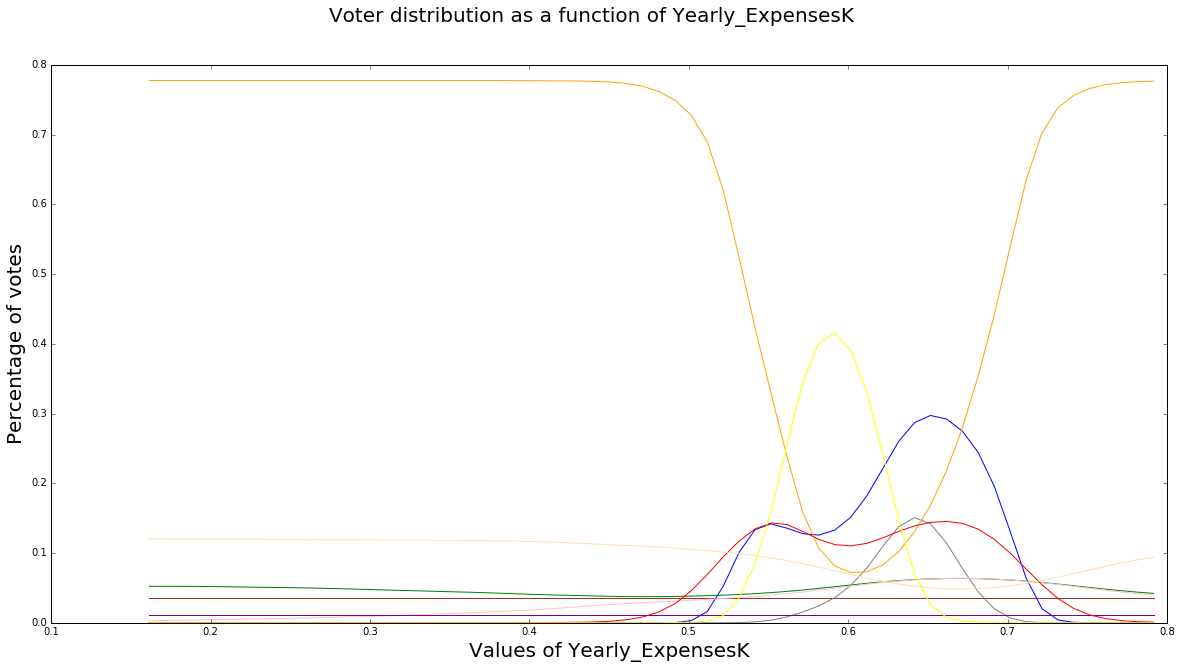

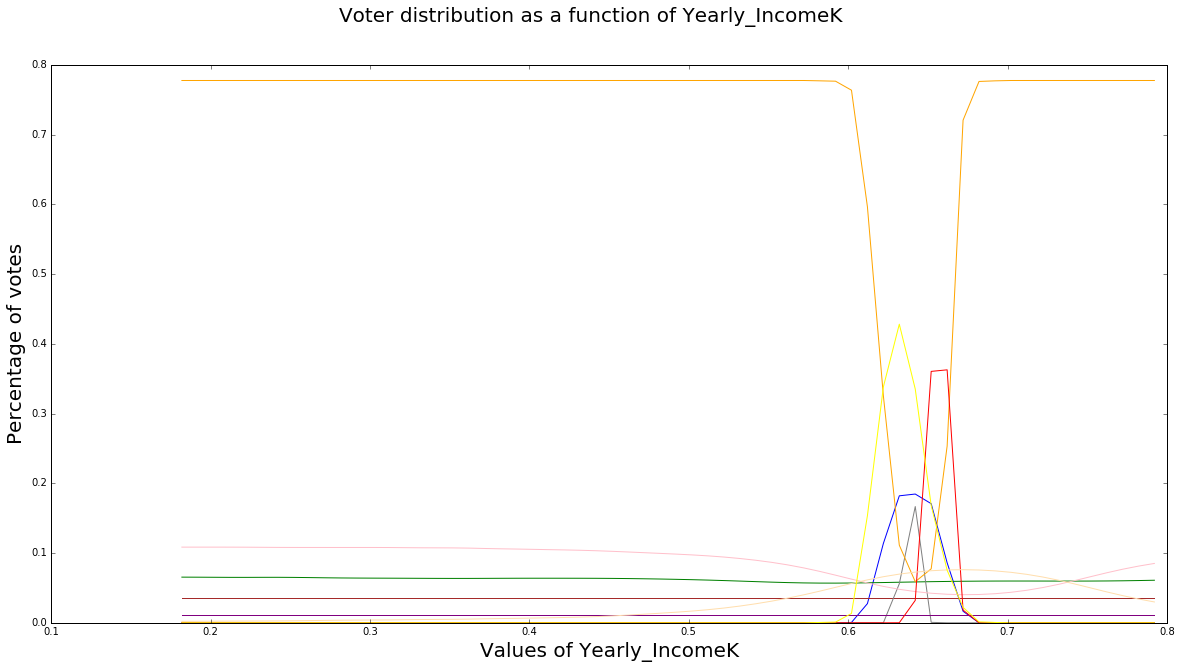

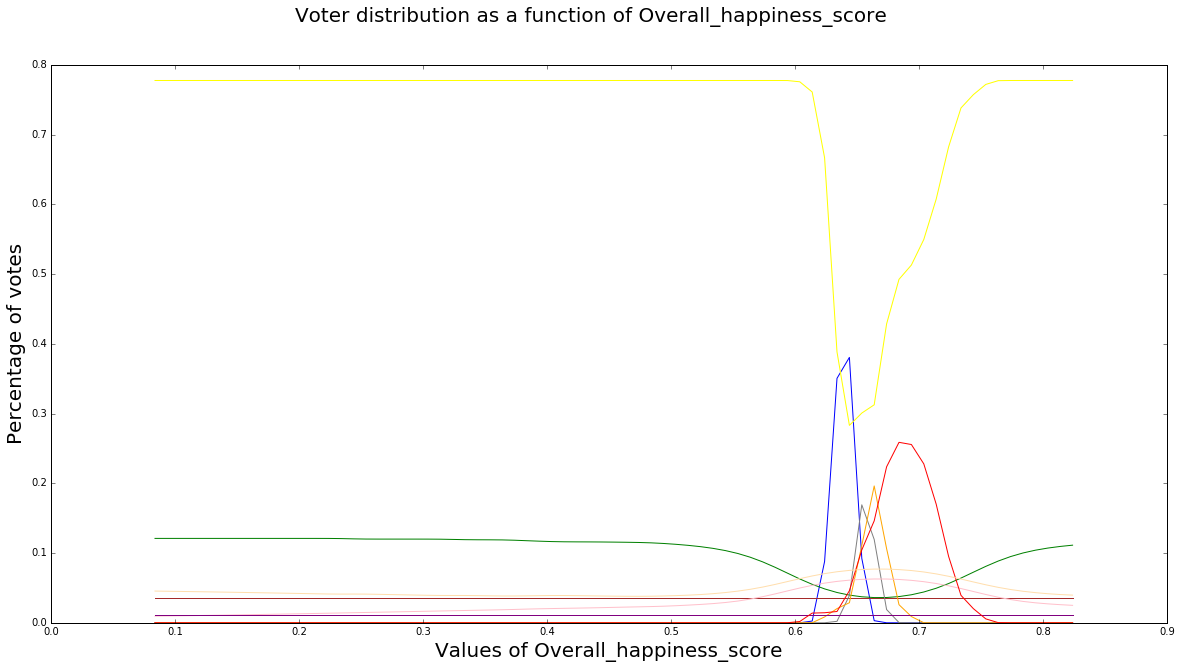

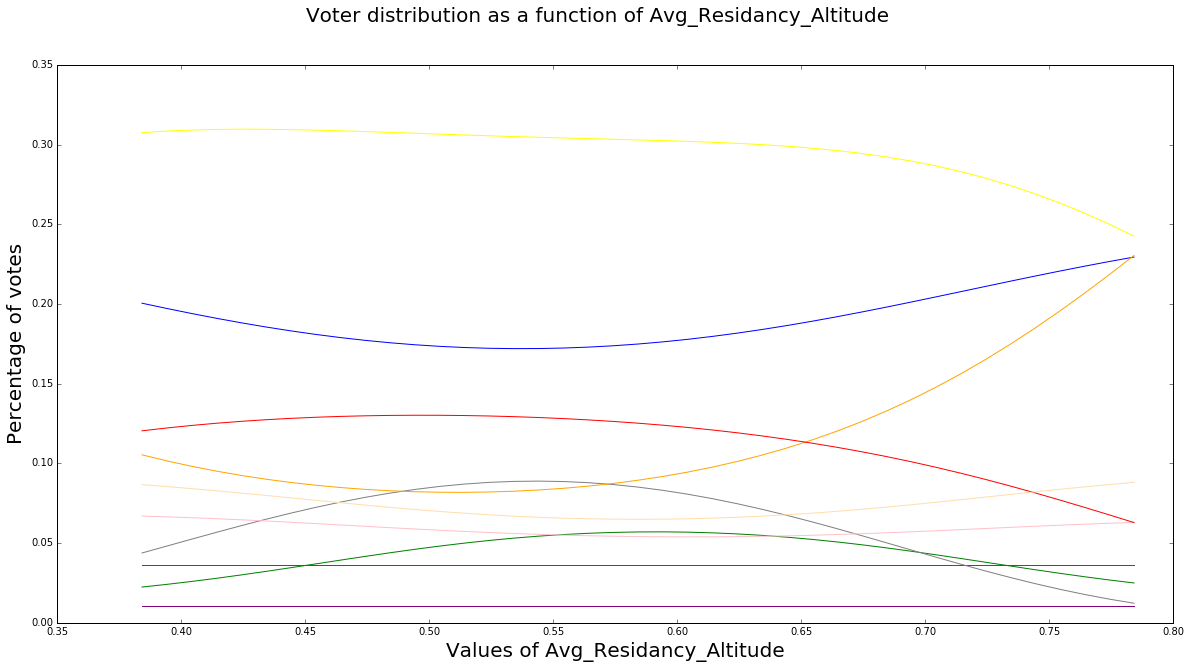

In [18]:
for attr in ['Yearly_ExpensesK','Yearly_IncomeK','Overall_happiness_score','Avg_Residancy_Altitude']:
    manipulate_data(clf,test_data,attr,upper_margin=0.1)

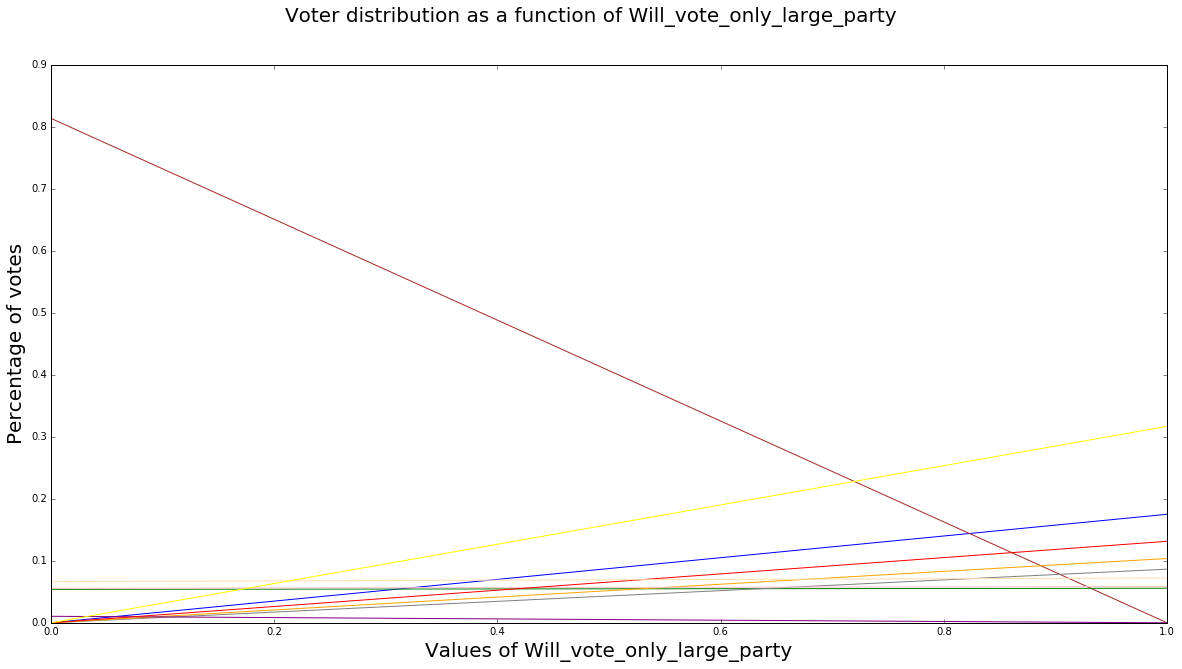

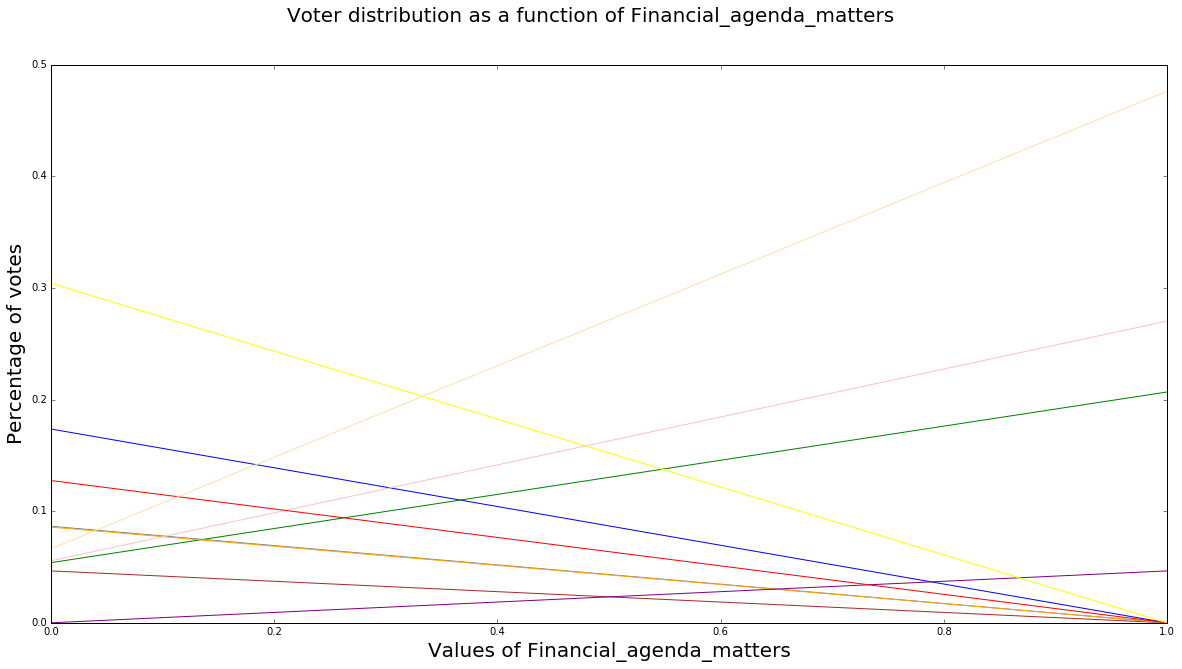

In [19]:
for attr in ['Will_vote_only_large_party','Financial_agenda_matters']:
    manipulate_data(clf,test_data,attr,step_size=1)

### Most Important Issue

We've tried the same thing for Most Important Issue but had problems graphing it.
We wanted to have 8 bar graphs (one for each most important issue), stacked with the votes.

The code works. Only the graphing does not... Maybe we could pie-chart it or something..

The idea was to zero the one-hot vectors and then set every instance in the test set to have the same "most important issue", plot the vote distribution, reset the vectors and repeat with a different issue.

In [20]:
def manipulate_most_important_issue(clf,df,verbose=False):
    df_copy = df.copy()
    issues = [a for a in df_copy.columns.values if 'Most_Important_Issue' in a]
    # zero the one-hot vectors
    def reset_most_important_issue():
        for attr in issues:
            for i in df_copy.index.values:
                df_copy[attr][i] = 0
    
    ratios = []

    for attr in issues:
        reset_most_important_issue()
        if verbose:
            print attr
        for i in df_copy.index.values:
                df_copy[attr][i] = 1        
        ratios.append(np.array([single_voter_distribution/df_copy.shape[0] for 
                                single_voter_distribution in 
                                [sum(single_voter_distribution) for 
                                 single_voter_distribution in zip(*clf.predict_proba(df_copy))]]))

    votes_dist = {}
    for i in range(clf.classes_.size):
        for idx in range(len(issues)):
            votes_dist[i] = np.array([party_dist[i] for party_dist in ratios])

    plot_colors = [x[:-1].lower() if x != 'Whites' else 'navajowhite' for x in clf.classes_]
    
    #fig, ax = plt.subplots(figsize=(20, 10))
    #title = 'Voter distribution as a function of ' + attr
    #fig.suptitle(title,fontsize=20)
    #label = 'Values of ' + attr
    #ax.set_xlabel(label,fontsize=20)
    #ax.set_ylabel('Percentage of votes',fontsize=20)
    #for i in range(clf.classes_.size):
    #    ax.plot(kind='bar', stacked=True, color=plot_colors)
    
    #ax.bar(range(len(issues)), issues, stacked=True, align="center",color=plot_colors)
    #plt.xticks(range(len(c)), issues, rotation=30)
    
    #plt.show()

#manipulate_most_important_issue(clf,test_data)

# Conclusions of factor manipulation

* People with high expenses vote for Greys. If everyone had high expenses, they would win.
* People with high incomes vote for Oranges. If everyone had high incomes, Oranges would win.
* People who live high up vote for Browns. If everyone lived in the mountains, Browns would win.
* At a certain range of Overall Happiness Oranges would win, outside of that range, Yellows would win.
* Overall Happiness and Yearly Income affect Blues and Yellows the same. Their graphs are very similar in this regard. When one drops, so does the other. When one rises, so does the other.
* People with high expenses but low incomes vote Pinks
* If everyone cared about the Financial Agenda, Whites would probably win. We saw in the data preparation (in the last exercise, not this one) that Financial Agenda Matters is unevenly distributed, so this could HIGHLY affect the vote results if you could change people's thinking about the financial agenda.
* If no one voted for a large party then browns would win, which would make them a large party, which means no one would vote for them.. but this part disregards any semantic meanins in the features.

And many, many more. The graphs tell a big story

# Task 4 - Key Factors to strengthen our coalition

In order to make our coalition even more stable, we need to take at least one of two courses of action:
1. Make the voters in the coalition more homogenous.
2. Make the coalition and opposition further apart.

In order to acheive this, we suggest the following method: identify the factor who's variance is biggest, and make it more uniform.
If we make it completely uniform across the coalition, then its contribution to the distance between voters will be 0.

In [21]:
coalition_data = get_voters_for_cluster(test, coalition)
opposition_data = get_voters_for_cluster(test, get_opposition_for_coalition(coalition))
np.std(coalition_data, axis=0) # Standard Deviation along clomuns

Yearly_ExpensesK                        0.028512
Yearly_IncomeK                          0.020991
Overall_happiness_score                 0.025588
Avg_Residancy_Altitude                  0.035834
Most_Important_Issue_Education          0.399815
Most_Important_Issue_Environment        0.392723
Most_Important_Issue_Financial          0.399815
Most_Important_Issue_Foreign_Affairs    0.000000
Most_Important_Issue_Healthcare         0.410050
Most_Important_Issue_Military           0.000000
Most_Important_Issue_Other              0.000000
Most_Important_Issue_Social             0.397019
Will_vote_only_large_party              0.205657
Financial_agenda_matters                0.000000
dtype: float64

In [22]:
np.sum(coalition_data, axis=0) # Sum along clomuns - good for one-hot-vectors

Yearly_ExpensesK                         995.724833
Yearly_IncomeK                          1041.581888
Overall_happiness_score                 1058.296379
Avg_Residancy_Altitude                   906.887847
Most_Important_Issue_Education           325.000000
Most_Important_Issue_Environment         310.000000
Most_Important_Issue_Financial           325.000000
Most_Important_Issue_Foreign_Affairs       0.000000
Most_Important_Issue_Healthcare          348.000000
Most_Important_Issue_Military              0.000000
Most_Important_Issue_Other                 0.000000
Most_Important_Issue_Social              319.000000
Will_vote_only_large_party              1555.000000
Financial_agenda_matters                   0.000000
dtype: float64

We see that "Most Important Issue" is not so uninform amogn the coalition (notice: these are one hot vectors, so the actual "sd" number does not reveal much by itself, but the fact they are spread almost across all issues tell us it differs between voters).

Let's make it uniform - imagine ALL coalition voters cared most about Healthcare (the current most common issue):

In [23]:
print "Stats before modification:"
print_coalition_scores(test, coalition)

Stats before modification:
The homogenity score for this colaition is: 881.919025427
The distance from it to the opposition is: 175.747990764
.... so the overall coalition score is: 1057.66701619


In [24]:
coalition_mask = get_voters_mask_for_cluster(test, coalition)
coalition_copy = test[coalition_mask].copy()
opposition_copy = test[np.logical_not(coalition_mask)].copy()
coalition_copy['Most_Important_Issue_Healthcare'].replace(0, 1, inplace=True)
coalition_copy['Most_Important_Issue_Education'].replace(1, 0, inplace=True)
coalition_copy['Most_Important_Issue_Environment'].replace(1, 0, inplace=True)
coalition_copy['Most_Important_Issue_Financial'].replace(1, 0, inplace=True)
coalition_copy['Most_Important_Issue_Foreign_Affairs'].replace(1, 0, inplace=True)
coalition_copy['Most_Important_Issue_Military'].replace(1, 0, inplace=True)
coalition_copy['Most_Important_Issue_Other'].replace(1, 0, inplace=True)
coalition_copy['Most_Important_Issue_Social'].replace(1, 0, inplace=True)
test_copy = pd.concat([coalition_copy, opposition_copy])

In [25]:
print "Stats AFTER modification:"
print_coalition_scores(test_copy, coalition)

Stats AFTER modification:
The homogenity score for this colaition is: 986.63310211
The distance from it to the opposition is: 175.930893688
.... so the overall coalition score is: 1162.5639958


### Conclusion:
We can see the homogenity score spiked, reaching almost 1000, which is the maximum possible score! not very surprising given the coalition was pretty homogenous to begin with, and we made an artificial change to unify them even more...

Notice: the distance from the opposition remained the same, meaning the oppositions most important issue is barely Healthcare (otherwise they'd become more similar), and that whatever issues they favor - the original coalition did not care much about in the first place - which is excellent, because it means that changing the feature itself shouldn't effect the division of voters between coalition parties and opposition parties